# Visualize the quantize embedding

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))
from utils.train_eval_scratch import VQVAE

In [2]:
import torch
import matplotlib.pyplot as plt
from einops import rearrange
from torchvision import transforms
from torch import Tensor

In [3]:
model_kwargs = dict(
    in_channel = 3,
    hid_channel = 128,
    n_res_block = 2,
    n_res_channel = 32,
    embd_dim = 64,
    n_embed = 512,
    scale_factor = 1,
)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VQVAE(**model_kwargs).to(device)
model_path = "../ckpt/unmask_vqvae_imagenet_10epo.pth"
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))

<All keys matched successfully>

In [5]:
image_size = 224
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])
def show_images(images:Tensor):
    return transforms.ToPILImage()(images)

## test pretrained model on cifar10

In [6]:
from torchvision.datasets import CIFAR10
root = "/data1/linkdom/data/"
cifar10 = CIFAR10(root=root, download=False, train=False, transform=transform)

horse


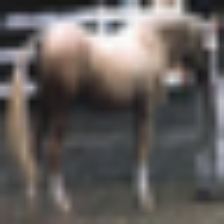

In [7]:
idx = torch.randint(0, len(cifar10), (1,)).item()
image, label = cifar10[idx]
print(cifar10.classes[label])
show_images(image)

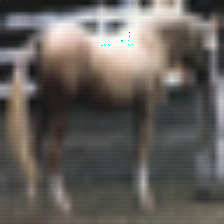

In [8]:
recon_image, quantize_idx = model(image.unsqueeze(0).to(device))
show_images(recon_image.squeeze(0))

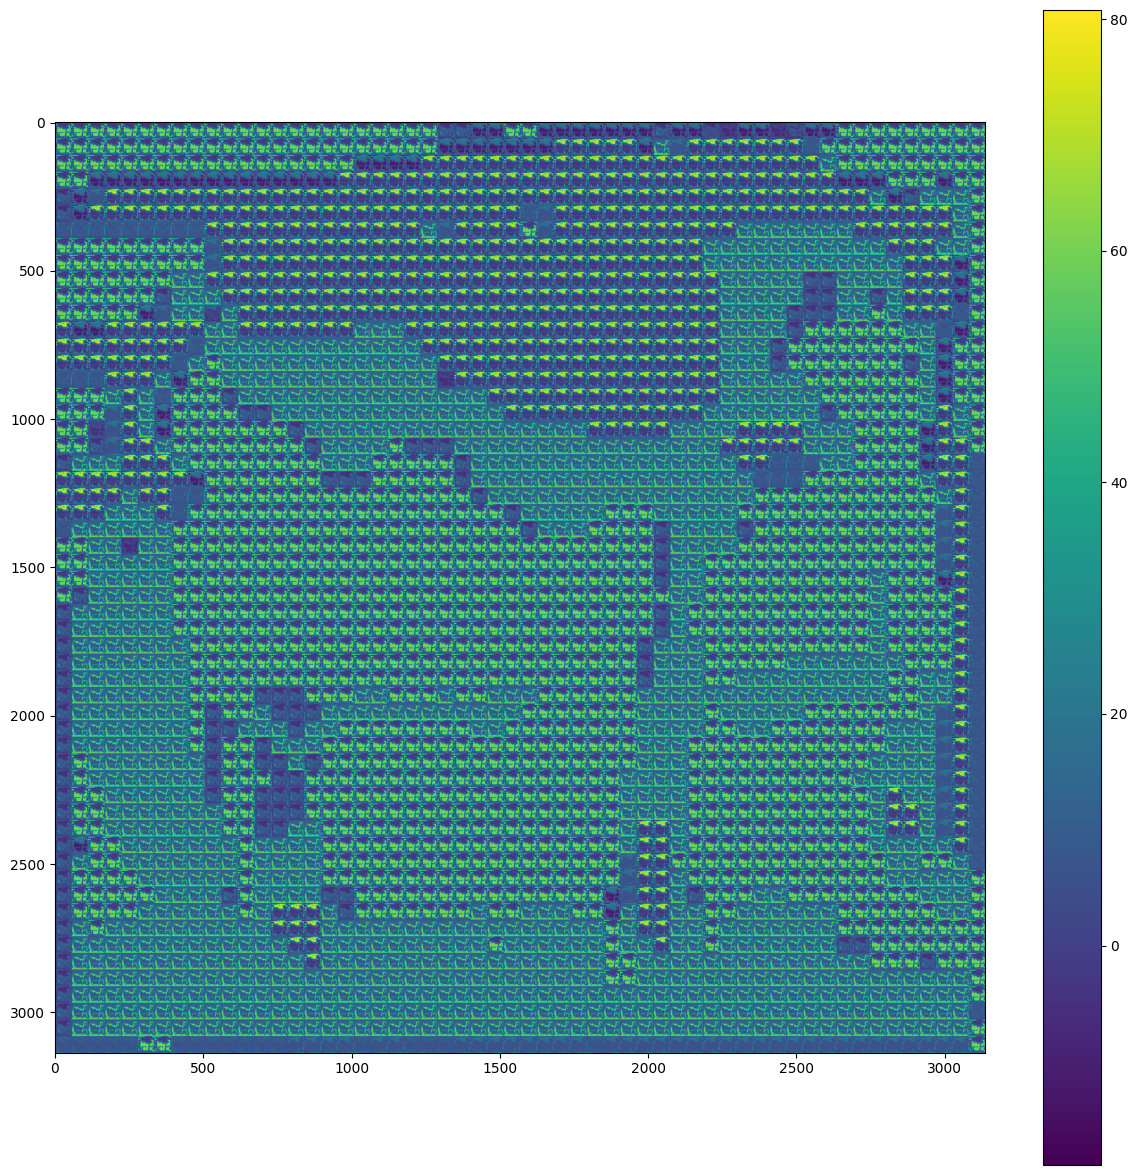

In [9]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
image_attention = (image_embd @ image_embd.T)
img_size = 56
image_attention = rearrange(
    image_attention, 
    '(h1 w1) (h2 w2) -> (h1 h2) (w1 w2)', 
    h1=img_size, w1=img_size, h2=img_size, w2=img_size
)

plt.figure(figsize=(15, 15))
plt.imshow(image_attention.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

## test pretrained model on your own picture

<div align="center"><img src="flower.png" width=200></div>


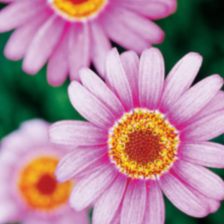

In [10]:
from PIL import Image

def load_image(path):
    img = Image.open(path).convert("RGB")
    img = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])(img)
    return img

image = load_image("flower.png")
show_images(image)

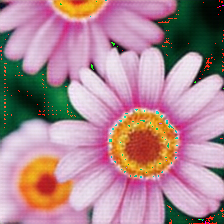

In [11]:
recon_image, quantize_idx = model(image.unsqueeze(0).to(device))
show_images(recon_image.squeeze(0))

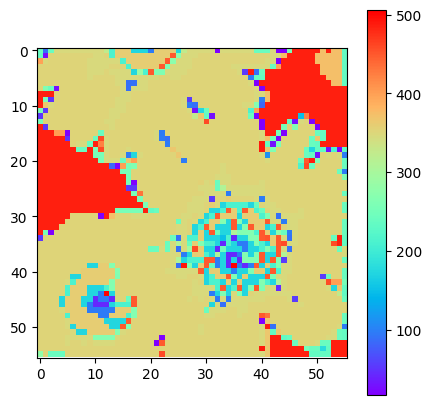

In [12]:
quantize_idx_label = rearrange(
    quantize_idx.squeeze(0),
    '(h w) -> h w',
    h=img_size, w=img_size
)
import matplotlib.cm as cm
import numpy as np
colors = cm.rainbow(np.linspace(0, 1, 512))

plt.figure(figsize=(5, 5))
plt.imshow(quantize_idx_label.cpu().detach().numpy(), cmap=cm.colors.ListedColormap(colors))
plt.colorbar()
plt.show()

torch.Size([3136, 64])


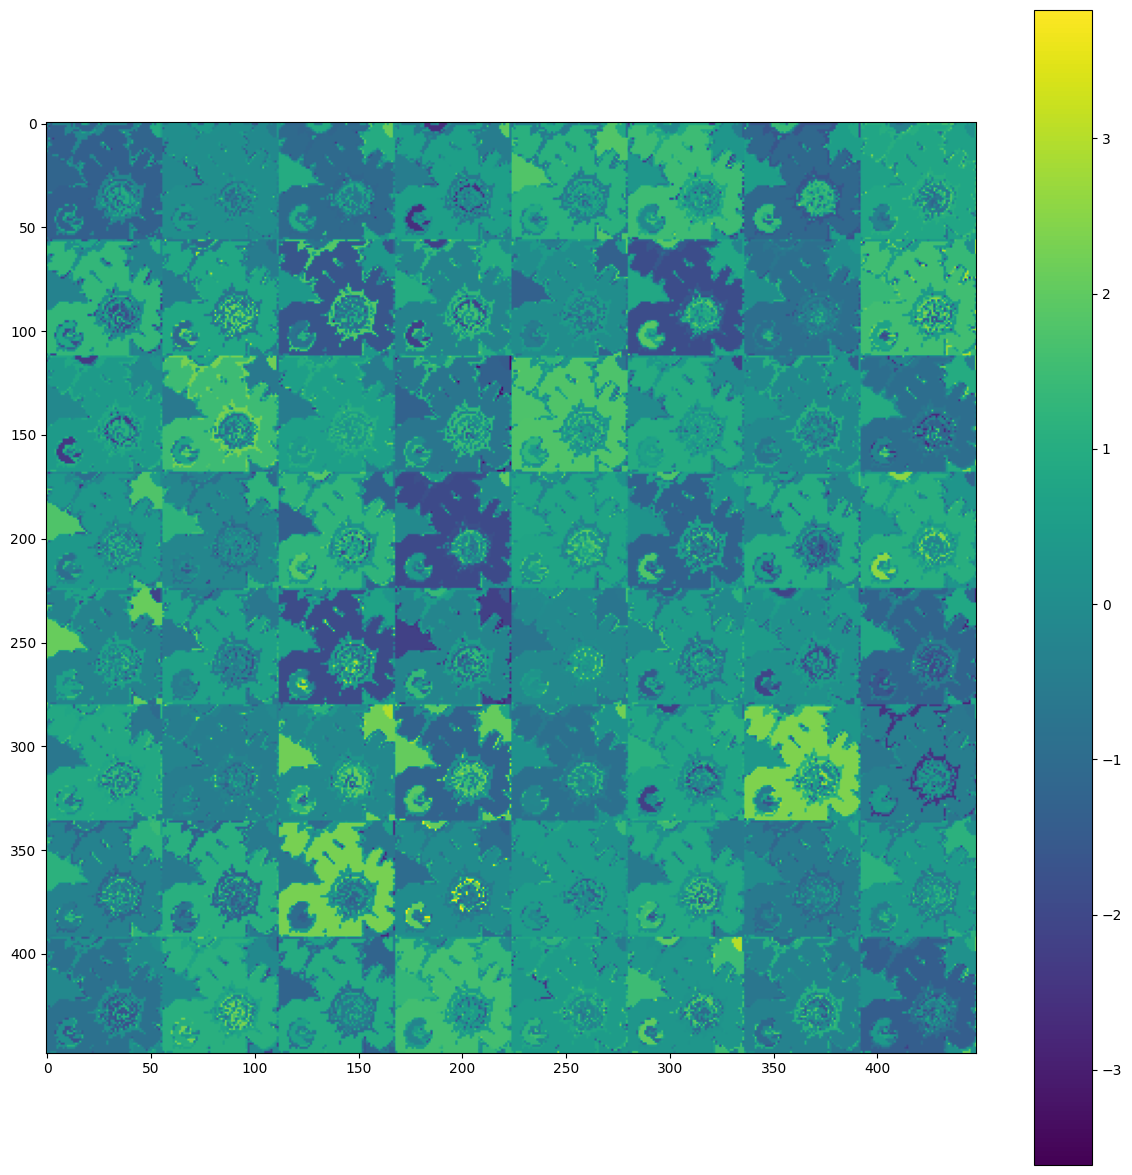

In [13]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
print(image_embd.shape)
image_embd = rearrange(
    image_embd, 
    '(h1 w1) (nh nw) -> (nh h1) (nw w1)', 
    h1=img_size, w1=img_size, nh = 8, nw = 8
)
plt.figure(figsize=(15, 15))
plt.imshow(image_embd.cpu().detach().numpy(), cmap="viridis") 
plt.colorbar()
plt.show()

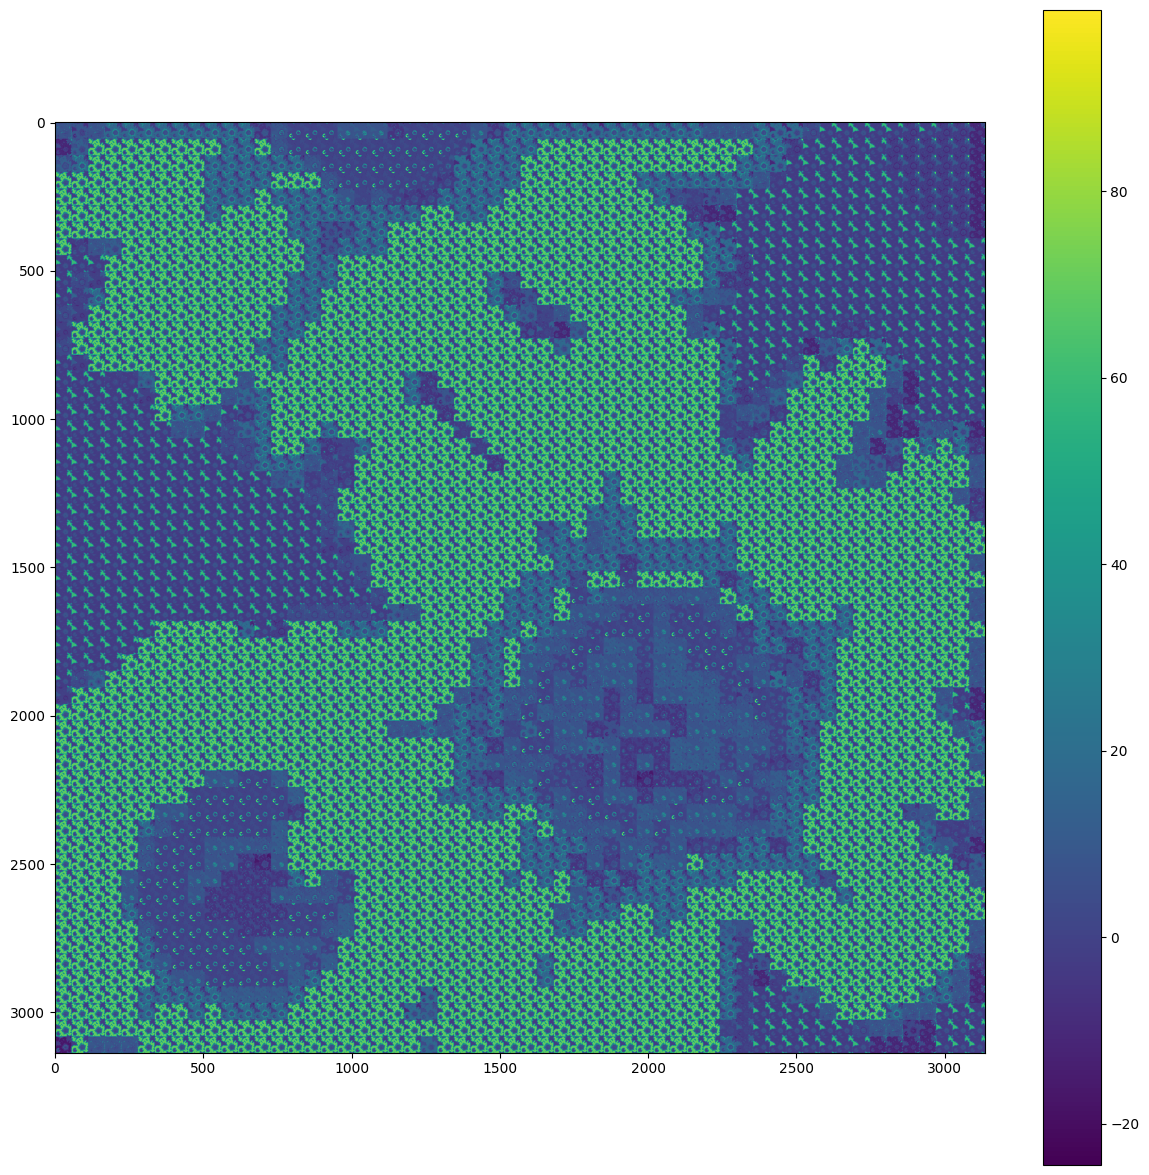

In [14]:
image_embd = model.quantize.embd(quantize_idx.squeeze(0))
image_attention = (image_embd @ image_embd.T)
img_size = 56
image_attention = rearrange(
    image_attention, 
    '(h1 w1) (h2 w2) -> (h1 h2) (w1 w2)', 
    h1=img_size, w1=img_size, h2=img_size, w2=img_size
)

plt.figure(figsize=(15, 15))
plt.imshow(image_attention.cpu().detach().numpy(), cmap="viridis")
plt.colorbar()
plt.show()

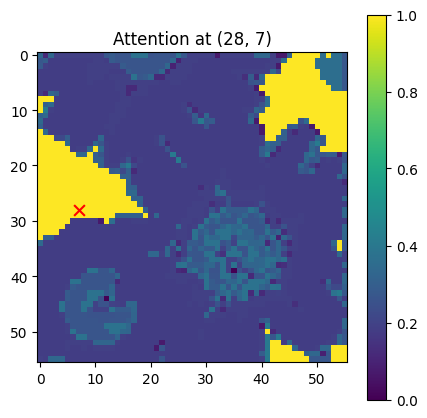

In [15]:
irow = torch.randint(0, 56, (1,)).item()
jcol = torch.randint(0, 56, (1,)).item()
y1, y2 = irow*img_size, (irow+1)*img_size
x1, x2 = jcol*img_size, (jcol+1)*img_size
partial_attention = image_attention[y1:y2, x1:x2]

plt.figure(figsize=(5, 5))
plt.imshow(partial_attention.cpu().detach().numpy(), cmap="viridis")
plt.scatter(jcol, irow, color="red", marker="x", s=60)
plt.colorbar()
plt.title(f"Attention at ({irow}, {jcol})")
plt.show()